In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
import seaborn as sns

In [2]:
# Đường dẫn dữ liệu
data_path = '/kaggle/input/ie403-doan/tiktok_comments_balanced_v2.csv'

In [3]:
# Đọc dữ liệu
comments = pd.read_csv(data_path, usecols=['emotion_label', 'text'])
comments = comments.dropna(subset=['emotion_label'])
comments['emotion_label'] = comments['emotion_label'].astype(int)

# Không xử lý gì văn bản — giữ nguyên
comments['text'] = comments['text'].astype(str)

In [4]:
# Tokenizer và Model
model_name = "uitnlp/visobert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
num_labels = 5
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/471k [00:00<?, ?B/s]

2025-06-14 07:36:29.344937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749886589.542874      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749886589.600342      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/390M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/visobert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Mã hóa dữ liệu
encoded_comments = tokenizer.batch_encode_plus(
    comments['text'].tolist(),
    add_special_tokens=True,
    padding='max_length',
    max_length=128,
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

input_ids = encoded_comments['input_ids']
attention_masks = encoded_comments['attention_mask']
labels = torch.tensor(comments['emotion_label'].values)

dataset = TensorDataset(input_ids, attention_masks, labels)

model.safetensors:   0%|          | 0.00/390M [00:00<?, ?B/s]

In [6]:
# Chia tập train/val
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [7]:
save_directory = '/kaggle/working/visobert'
os.makedirs(save_directory, exist_ok=True)

In [8]:
# Thiết bị
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Tính class weights
all_labels = []
for batch in train_loader:
    _, _, labels = batch
    all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = CrossEntropyLoss(weight=class_weights)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 10
patience = 3
best_accuracy = 0
patience_counter = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    true_labels, pred_labels = [], []
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            pred_labels.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = accuracy_score(true_labels, pred_labels)
    val_accuracies.append(accuracy)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {accuracy:.4f}")

    # Early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': accuracy,
            'loss': avg_val_loss
        }, "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping tại epoch {epoch+1} (val_acc không cải thiện sau {patience} epoch)")
            break

print("\nTraining completed!")
print(f"Best Validation Accuracy: {best_accuracy:.4f}")

# Lưu model
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Training Epoch 1:   0%|          | 0/776 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/87 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 0.9746 | Val Loss: 0.8900 | Val Accuracy: 0.6560


Training Epoch 2:   0%|          | 0/776 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/87 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 0.6183 | Val Loss: 0.9091 | Val Accuracy: 0.6626


Training Epoch 3:   0%|          | 0/776 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/87 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 0.3438 | Val Loss: 1.1121 | Val Accuracy: 0.6531


Training Epoch 4:   0%|          | 0/776 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/87 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 0.2081 | Val Loss: 1.3792 | Val Accuracy: 0.6538


Training Epoch 5:   0%|          | 0/776 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/87 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 0.1655 | Val Loss: 1.4881 | Val Accuracy: 0.6582
Early stopping tại epoch 5 (val_acc không cải thiện sau 3 epoch)

Training completed!
Best Validation Accuracy: 0.6626


('/kaggle/working/visobert/tokenizer_config.json',
 '/kaggle/working/visobert/special_tokens_map.json',
 '/kaggle/working/visobert/sentencepiece.bpe.model',
 '/kaggle/working/visobert/added_tokens.json',
 '/kaggle/working/visobert/tokenizer.json')

In [9]:
# Dự đoán mẫu
label_names = {
    0: 'Vui vẻ',
    1: 'Tức giận',
    2: 'Buồn bã',
    3: 'Sợ hãi',
    4: 'Khác'
}

In [ ]:
checkpoint = torch.load("best_model.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

true_labels, pred_labels = [], []
with torch.no_grad():
    for batch in tqdm(val_loader, desc="Predicting Best Model"):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        pred_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, pred_labels, target_names=list(label_names.values()), digits=4))

Predicting Best Model:   0%|          | 0/87 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      Vui vẻ     0.5919    0.4783    0.5291       276
    Tức giận     0.6780    0.6605    0.6692       271
     Buồn bã     0.6757    0.7168    0.6957       279
      Sợ hãi     0.8333    0.8052    0.8190       267
        Khác     0.5549    0.6561    0.6013       285

    accuracy                         0.6626      1378
   macro avg     0.6668    0.6634    0.6628      1378
weighted avg     0.6649    0.6626    0.6615      1378



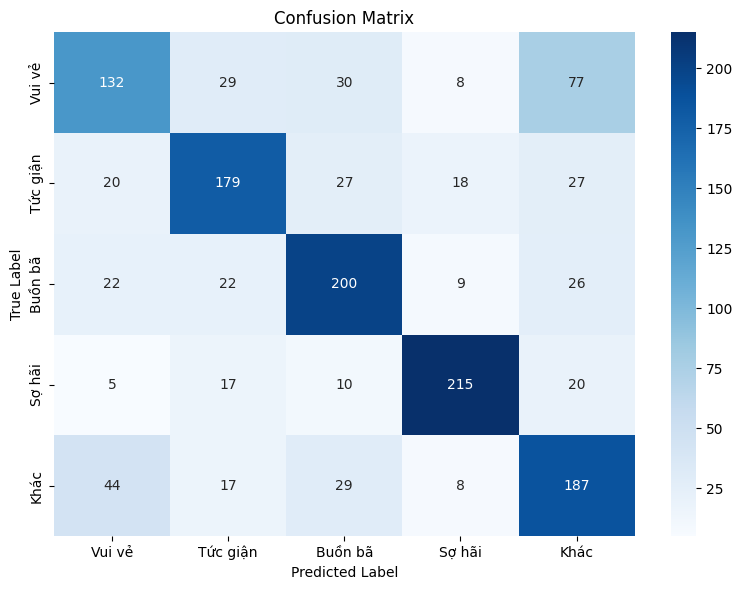

In [11]:
# Ma trận nhầm lẫn
cm = confusion_matrix(true_labels, pred_labels)
labels = list(label_names.values())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [12]:
# Load lại mô hình tốt nhất từ file .pth
checkpoint = torch.load("best_model.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.to(device)
print(f"\nĐã load mô hình tốt nhất tại epoch {checkpoint['epoch']} với val_acc = {checkpoint['val_accuracy']:.4f}")


Đã load mô hình tốt nhất tại epoch 2 với val_acc = 0.6626


In [13]:
print("\n--- Examples of Predictions ---")
for i in range(10):
    pred = pred_labels[i]
    true = true_labels[i]
    text = comments.iloc[val_dataset.indices[i]]['text']
    status = "✅ Correct" if pred == true else "❌ Incorrect"
    print(f"{status} | Text: {text}\n  Predicted: {label_names[pred]}, Actual: {label_names[true]}\n")



--- Examples of Predictions ---
❌ Incorrect | Text: sao mk ko gặp nhỉ
  Predicted: Khác, Actual: Vui vẻ

✅ Correct | Text: cuối xin pháp_luật hãy mạnh_tay với mấy em
  Predicted: Tức giận, Actual: Tức giận

❌ Incorrect | Text: đàn_ông ngoại_tình_nể mỗi sếp
  Predicted: Vui vẻ, Actual: Tức giận

✅ Correct | Text: vào phở bò cô ấy đáng thương lắm mn ạ_thương gia_đình cô lắm
  Predicted: Buồn bã, Actual: Buồn bã

❌ Incorrect | Text: có nên yêu em nhà bán gas không
  Predicted: Vui vẻ, Actual: Khác

✅ Correct | Text: đi ra đường h sợ v
  Predicted: Sợ hãi, Actual: Sợ hãi

❌ Incorrect | Text: tao chỉ để_ý cái khách_sạn thôi
  Predicted: Khác, Actual: Vui vẻ

✅ Correct | Text: ngầu chưa kịp 3 s
  Predicted: Vui vẻ, Actual: Vui vẻ

❌ Incorrect | Text: hong nhur
  Predicted: Khác, Actual: Vui vẻ

✅ Correct | Text: k có cưứ hỏa à
  Predicted: Khác, Actual: Khác



In [14]:
def predict_text(text):
    model.eval()
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=128,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoded['input_ids'].to(model.device)
    attention_mask = encoded['attention_mask'].to(model.device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    print(f"\n Dự đoán cảm xúc: {label_names[predicted_class]}")


In [15]:
test_texts = [
    "nghe bạn nam bảo : khổ thế nhờ đã dịch cô vít thì chớ mà xót🥺",
    "mày giỡn mặt tao à?",
    "trời ơi vui quá đi 😍 hôm nay được nghỉ học",
    "bạn nữ đó nhìn buồn thật sự",
    "tôi cảm thấy lo lắng khi ra đường bây giờ",
    "haiz, chẳng còn gì để nói nữa",
    "mấy bạn bình tĩnh, chuyện đâu còn có đó",
    "cảm ơn bạn rất nhiều vì đã giúp tôi",
    "tôi ghét cái cách bạn đối xử với tôi",
    "mình rất hồi hộp chờ kết quả thi"
]

for text in test_texts:
    print(f"\n Bình luận: {text}")
    predict_text(text)



 Bình luận: nghe bạn nam bảo : khổ thế nhờ đã dịch cô vít thì chớ mà xót🥺

 Dự đoán cảm xúc: Buồn bã

 Bình luận: mày giỡn mặt tao à?

 Dự đoán cảm xúc: Tức giận

 Bình luận: trời ơi vui quá đi 😍 hôm nay được nghỉ học

 Dự đoán cảm xúc: Vui vẻ

 Bình luận: bạn nữ đó nhìn buồn thật sự

 Dự đoán cảm xúc: Buồn bã

 Bình luận: tôi cảm thấy lo lắng khi ra đường bây giờ

 Dự đoán cảm xúc: Sợ hãi

 Bình luận: haiz, chẳng còn gì để nói nữa

 Dự đoán cảm xúc: Buồn bã

 Bình luận: mấy bạn bình tĩnh, chuyện đâu còn có đó

 Dự đoán cảm xúc: Khác

 Bình luận: cảm ơn bạn rất nhiều vì đã giúp tôi

 Dự đoán cảm xúc: Vui vẻ

 Bình luận: tôi ghét cái cách bạn đối xử với tôi

 Dự đoán cảm xúc: Tức giận

 Bình luận: mình rất hồi hộp chờ kết quả thi

 Dự đoán cảm xúc: Vui vẻ


In [16]:
!zip -r /kaggle/working/visobert.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/visobert/ (stored 0%)
  adding: kaggle/working/visobert/config.json (deflated 53%)
  adding: kaggle/working/visobert/tokenizer.json (deflated 79%)
  adding: kaggle/working/visobert/tokenizer_config.json (deflated 76%)
  adding: kaggle/working/visobert/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 7%)
  adding: kaggle/working/visobert/special_tokens_map.json (deflated 52%)
  adding: kaggle/working/visobert/sentencepiece.bpe.model (deflated 50%)
  adding: kaggle/working/best_model.pth (deflated 14%)
